In [1]:
from config import domainData
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
%matplotlib inline 
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

use_gpu = True and torch.cuda.is_available()
train_dir = domainData['amazon'] # 'amazon', 'dslr', 'webcam'
val_dir = domainData['webcam']

image_datasets = {'train' : datasets.ImageFolder(train_dir,
                                          data_transforms['train']),
                  'val' : datasets.ImageFolder(val_dir,
                                          data_transforms['val'])
                 }
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/home/utkrsh/anaconda3/envs/pytorch/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
/home/utkrsh/anaconda3/envs/pytorch/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

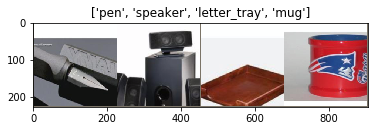

In [4]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 31)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.3846 Acc: 0.3532
val Loss: 1.9815 Acc: 0.4843

Epoch 1/24
----------
train Loss: 1.6878 Acc: 0.5300
val Loss: 1.7020 Acc: 0.5673

Epoch 2/24
----------
train Loss: 1.4610 Acc: 0.5982
val Loss: 1.8610 Acc: 0.5484

Epoch 3/24
----------
train Loss: 1.3576 Acc: 0.6344
val Loss: 2.0336 Acc: 0.5157

Epoch 4/24
----------
train Loss: 1.3126 Acc: 0.6532
val Loss: 2.0373 Acc: 0.5082

Epoch 5/24
----------
train Loss: 1.2104 Acc: 0.6759
val Loss: 2.0616 Acc: 0.5057

Epoch 6/24
----------
train Loss: 1.1351 Acc: 0.6933
val Loss: 2.1230 Acc: 0.5321

Epoch 7/24
----------
train Loss: 0.8691 Acc: 0.7604
val Loss: 1.7219 Acc: 0.5836

Epoch 8/24
----------
train Loss: 0.7459 Acc: 0.8033
val Loss: 1.8107 Acc: 0.5660

Epoch 9/24
----------
train Loss: 0.6970 Acc: 0.8090
val Loss: 1.8605 Acc: 0.5283

Epoch 10/24
----------
train Loss: 0.6930 Acc: 0.8083
val Loss: 1.9901 Acc: 0.5358

Epoch 11/24
----------
train Loss: 0.6762 Acc: 0.8126
val Loss: 1.8884 Acc: 0.5522

Ep